In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.ndimage import distance_transform_edt as dst
import sys
sys.path.insert(0,r'../src')
from Vsi import Vsi, rock_type, read_image
import os
import tifffile
import glob

## Load and visualize data

In [4]:
# Reading Images
img_list = glob.glob('../Data/*.ubc')
gambier, castlegate, beadpack, sandpack = [np.fromfile(img,dtype='uint8') for img in img_list]

# Reshaping Images
gambier = gambier.reshape((512,512,512))
castlegate = castlegate.reshape((512,512,512))
beadpack = beadpack.reshape((512,512,512))
sandpack = sandpack.reshape((512,512,512))

# Iverting the binary arrays (switching void and solid phases)
gambier = np.invert(gambier==True).astype('uint8')
castlegate = np.invert(castlegate==True).astype('uint8')
beadpack = np.invert(beadpack==True).astype('uint8')
sandpack = np.invert(sandpack==True).astype('uint8')

prepared_images = [gambier,castlegate,beadpack,sandpack]

### Scale-independent Variance

In [5]:
res={}
for i, f_name in enumerate(img_list):
    im = prepared_images[i]
    # ----- get the relative radius-----------
    ds=dst(im[0]) # distance map of a slice, for fast computation. 
    mn_r1 = int(ds.max()) # maximum width of pores is used as minimum radius for moving windows
    mx_r1 = mn_r1+100
    #print('starting radius for '+f_name[:-4]+' is '+str(mn_r1)+' voxels')
    #------run the Vsi--------------
    vf = Vsi(im, no_radii=20,
         no_samples_per_radius=200,
         min_radius=mn_r1, max_radius=mx_r1)
    res[f_name[:-4]] = vf

100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Plot result

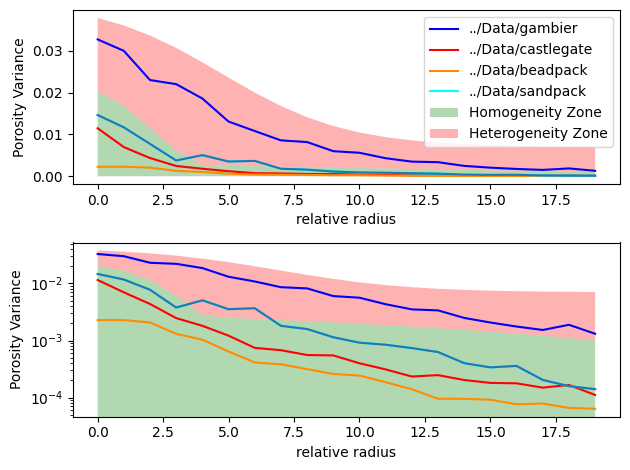

In [11]:
colors = ['blue', 'red', 'darkorange', 'cyan']
plt.subplot(211)
for i, k in enumerate(res.keys()):
    plt.plot(res[k].variance, label=k, color=colors[i])
res[k].plot()

plt.subplot(212)
for i, k in enumerate(res.keys()):
    plt.plot(res[k].variance, label=k, color=colors[i])
res[k].plot(fill=1,legend=0)
plt.yscale('log')
plt.tight_layout()

In [12]:
for k in res.keys():
    print(k,res[k].rock_type())

../Data/gambier 0.9999999999999999
../Data/castlegate 0.0
../Data/beadpack 0.0
../Data/sandpack 0.21319406691164505


In [14]:
# result for 1 sample
res[k].result()

,Radii,Variance
0,"[20, 25, 30, 35, 41, 46, 51, 56, 62, 67, 72, 7...","[0.014637549613255953, 0.011698918547092705, 0..."


In [15]:
df = pd.DataFrame(columns=['Radii','Variance','Sample'])
for k in res.keys():
    df0 = res[k].result()
    df0['Sample']=k
    df = pd.concat([df,df0])
df

,Radii,Variance,Sample
0,"[35, 40, 45, 50, 56, 61, 66, 71, 77, 82, 87, 9...","[0.03269408694566054, 0.029966565999080496, 0....",../Data/gambier
0,"[12, 17, 22, 27, 33, 38, 43, 48, 54, 59, 64, 6...","[0.0114744442761216, 0.006974037626784758, 0.0...",../Data/castlegate
0,"[48, 53, 58, 63, 69, 74, 79, 84, 90, 95, 100, ...","[0.0022768643780080367, 0.002280879815540765, ...",../Data/beadpack
0,"[20, 25, 30, 35, 41, 46, 51, 56, 62, 67, 72, 7...","[0.014637549613255953, 0.011698918547092705, 0...",../Data/sandpack
